# Self Driving Car Steering Angle Prediction & Simulation

**Load all required libraries and dependencies**

In [25]:
#pip install keras
#!pip install tensorflow
#! pip install cv
#!pip install imgaug

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

## Keras
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense

import cv2
import pandas as pd
import random
import ntpath
import albumentations as A

##  Sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

**Load Data**

In [27]:
!git clone https://github.com/rslim087a/track.git

fatal: destination path 'track' already exists and is not an empty directory.


In [28]:
!ls track

driving_log.csv  IMG


**Explore Data**


* The dataset has 6 columns – center, left, right (camera image paths), steering, throttle, brake, speed (values).



In [29]:
datadir = 'track'
columns = ['center','left','right','steering','throttle','reverse','speed']
data = pd.read_csv(os.path.join(datadir,'driving_log.csv'),names = columns)
pd.set_option('display.max_colwidth',None)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


In [30]:
print('total data',len(data))
print(data.shape)

total data 4053
(4053, 7)


+ Since the prefix of the left, right, and center image paths was the same for all rows, we remove the prefix part in the dataset.

In [31]:
# removes the folder path and keeps only the file names for images in the dataset
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


+ Next, we plot the distribution of the steering angle values

In [32]:
num_bins = 25
samples_per_bin = 200
hist , bins = np.histogram(data['steering'], num_bins)

In [33]:
print(bins)

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


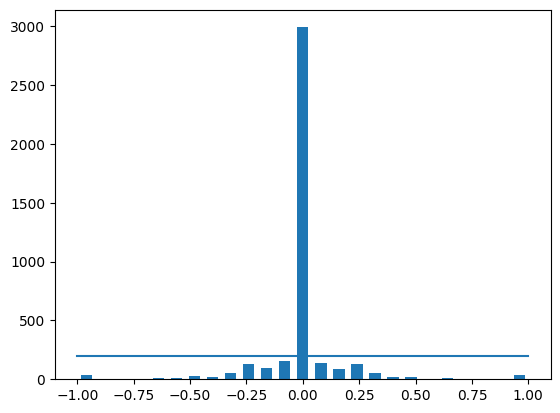

In [34]:
center = (bins[:-1]+ bins[1:]) * 0.5 # center the bins to 0
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),
         (samples_per_bin, samples_per_bin))

**Data Splitting**


In [35]:
ls track/IMG

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
center_2018_07_16_17_13_01_434.jpg*  left_2018_07_16_17_15_25_144.jpg*
center_2018_07_16_17_13_01_503.jpg*  left_2018_07_16_17_15_25_216.jpg*
center_2018_07_16_17_13_01_574.jpg*  left_2018_07_16_17_15_25_290.jpg*
center_2018_07_16_17_13_01_650.jpg*  left_2018_07_16_17_15_25_362.jpg*
center_2018_07_16_17_13_01_722.jpg*  left_2018_07_16_17_15_25_433.jpg*
center_2018_07_16_17_13_01_793.jpg*  left_2018_07_16_17_15_25_500.jpg*
center_2018_07_16_17_13_01_859.jpg*  left_2018_07_16_17_15_25_574.jpg*
center_2018_07_16_17_13_01_931.jpg*  left_2018_07_16_17_15_25_641.jpg*
center_2018_07_16_17_13_02_004.jpg*  left_2018_07_16_17_15_25_710.jpg*
center_2018_07_16_17_13_02_076.jpg*  left_2018_07_16_17_15_25_779.jpg*
center_2018_07_16_17_13_02_145.jpg*  left_2018_07_16_17_15_25_849.jpg*
center_2018_07_16_17_13_02_216.jpg*  left_2018_07_16_17_15_25_919.jpg*
center_2018_07_16_17_13_02_286.jpg*  left_2018_07_16_17_15_25_989.jpg*

In [36]:
# Specify path of the images folder
image_folder = 'track/IMG'

image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

# Nbr of imgs in the folder
num_images = len(image_files)

print(f"Le dossier '{image_folder}' contient {num_images} images.")

Le dossier 'track/IMG' contient 12159 images.


+ Create a function to load all the images as well as the steering angle values into a NumPy array

In [37]:
def load_img_steering(datadir, df):
    image_path = []
    steering = []

    for i in range(len(df)):
        indexed_data = df.iloc[i]  # get the i-th row as Series

        # Use .iloc for positional indexing
        center = indexed_data.iloc[0]
        left   = indexed_data.iloc[1]
        right  = indexed_data.iloc[2]
        steer  = float(indexed_data.iloc[3])

        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(steer)

    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

# Usage
image_paths, steerings = load_img_steering(image_folder, data)

+ The next step is to split the data using the 80-20 rule, meaning 80% of the data is used for training while the rest is used to test the model on unseen images.

Training Samples: 3242
Test Samples:811


Text(0.5, 1.0, 'Test set')

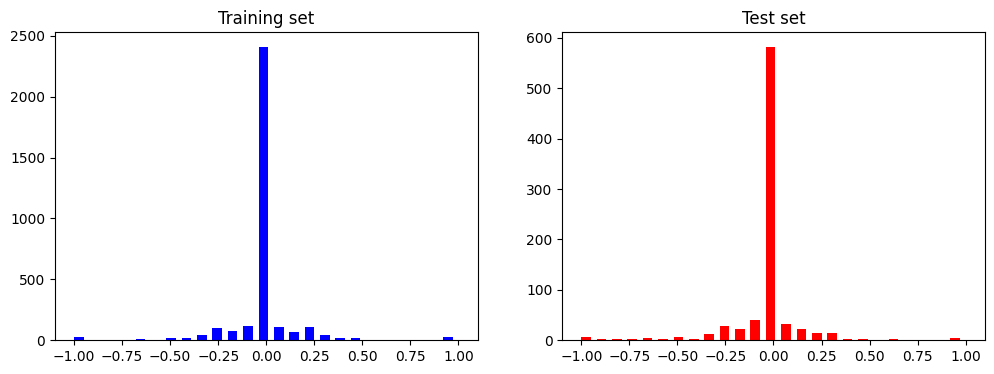

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(image_paths,steerings,test_size = 0.2, random_state=0)

print("Training Samples: {}\nTest Samples:{}".format(len(X_train),len(X_test)))
fig, axes = plt.subplots(1,2, figsize=(12, 4))
axes[0].hist(Y_train, bins=num_bins, width = 0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(Y_test, bins=num_bins, width = 0.05, color='red')
axes[1].set_title('Test set')

**Data Preprocessing**
+ Image preprocessing: Crop the image to remove unnecessary features, convert the images to YUV format, apply Gaussian blur, reduce the size for easier processing, and normalize the values

In [39]:
def img_preprocess(img):
    img = mpimg.imread(img)
    # crop image to remove unnecessary features
    img = img[60:135, :, :]
    # change to YUV image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    # Gaussian blur
    img = cv2.GaussianBlur(img, (3,3),0)
    # Decrease size for easier processing
    img = cv2.resize(img, (100,100))
    # Normalize values
    img = img / 255
    return img

+ For comparison and visualization, we plot the original and preprocessed images

Text(0.5, 1.0, 'Preprocessed Image')

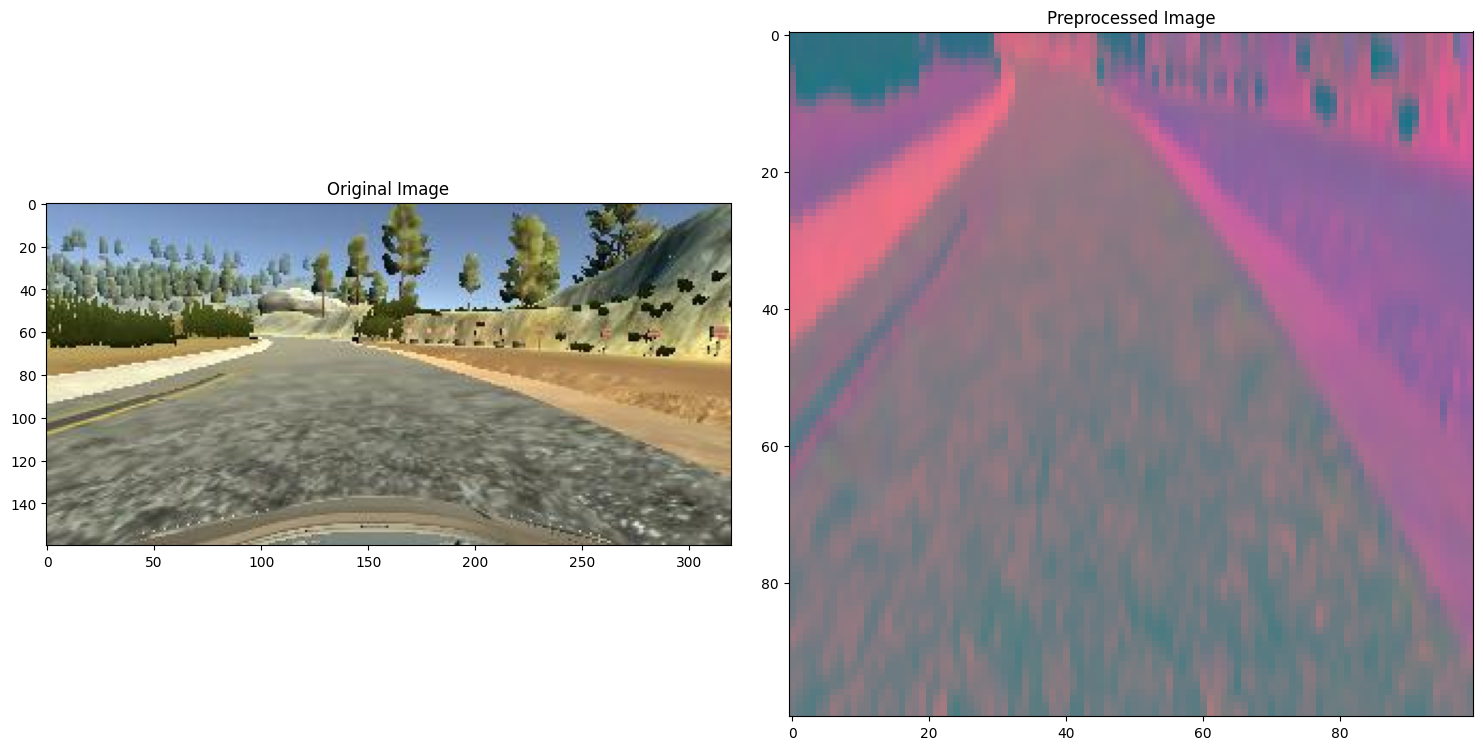

In [40]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig,axes = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')

+ Apply preprocessing to dataset

In [41]:
# Preprocess training /test images
X_train_prep = np.array([img_preprocess(x) for x in X_train])
X_test_prep = np.array([img_preprocess(x) for x in X_test])

**Data Augmentation**
+ Define the augmentation functions

In [42]:
# Zoom images
def zoom(image, steering_angle):
    transform = A.Compose([
        A.RandomScale(scale_limit=(0.0, 0.3), p=1.0)  # zoom in/out up to ±30%
    ])
    augmented = transform(image=image)['image']
    return augmented, steering_angle

# Pan / Shift images horizontally/vertically
def pan(image, steering_angle):
    transform = A.Compose([
        A.ShiftScaleRotate(
            shift_limit=0.1,       # ±10% horizontal/vertical shift
            scale_limit=0.0,       # keep scale unchanged
            rotate_limit=0,        # no rotation
            p=1.0
        )
    ])
    augmented = transform(image=image)['image']

    # Optional: adjust steering based on horizontal shift
    # steering_angle += horizontal_shift_factor
    return augmented, steering_angle

# Adjust brightness randomly
def img_random_brightness(image, steering_angle):
    transform = A.Compose([
        A.RandomBrightnessContrast(
            brightness_limit=0.8,  # reduce or increase brightness
            contrast_limit=0.0,    # keep contrast unchanged
            p=1.0
        )
    ])
    augmented = transform(image=image)['image']
    return augmented, steering_angle

# Flip horizontally
def img_random_flip(image, steering_angle):
    transform = A.Compose([
        A.HorizontalFlip(p=1.0)
    ])
    augmented = transform(image=image)['image']
    return augmented, -steering_angle  # flip steering angle



+ Apply random augmentation functions to a single image

In [43]:
def augment_image(image, steering_angle):
    # Apply every augmentation
    image, steering_angle = zoom(image, steering_angle)
    image, steering_angle = pan(image, steering_angle)
    #image, steering_angle = img_random_brightness(image, steering_angle)
    #image, steering_angle = img_random_flip(image, steering_angle)
    return image, steering_angle


In [44]:
X_train_aug = []
Y_train_aug = []

for img, steering in zip(X_train_prep, Y_train):
    # original image
    X_train_aug.append(img)
    Y_train_aug.append(steering)

    # generate N augmented copies
    for _ in range(2):  # 2 extra copies
        img_aug, steering_aug = augment_image(img, steering)
        # Resize to fixed shape
        img_aug = cv2.resize(img_aug, (100, 100))
        X_train_aug.append(img_aug)
        Y_train_aug.append(steering_aug)

# Convert to NumPy arrays
X_train_aug = np.array(X_train_aug)
Y_train_aug = np.array(Y_train_aug)

print("Training samples after augmentation:", len(X_train_aug))


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Training samples after augmentation: 9726


+ Visualize augmented training images

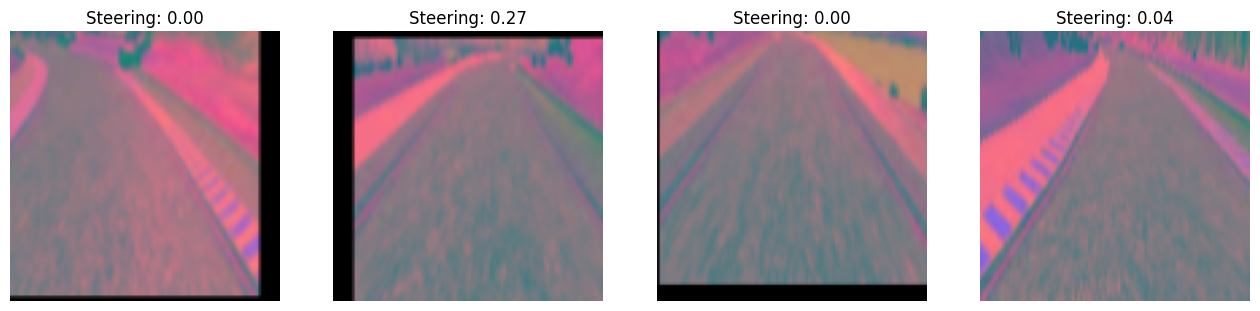

In [45]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(16,4))
for i, ax in enumerate(axes):
    idx = random.randint(0, len(X_train_aug)-1)
    ax.imshow(X_train_aug[idx])
    ax.set_title(f"Steering: {Y_train_aug[idx]:.2f}")
    ax.axis('off')
plt.show()


**Model Creation**
+ The next step is to build the model. We use VGG19 and remove the last 4 layers to create a custom neural network

In [55]:
from tensorflow.keras.applications import VGG19

# Load pretrained VGG19 without top layers
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(100,100,3))

# Freeze all layers except the last 4
for layer in vgg19.layers[:-10]:
    layer.trainable = False

# Check which layers are trainable
for layer in vgg19.layers:
    print(layer.name, layer.trainable)

input_layer_4 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_conv4 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_conv4 True
block5_pool True


+ In addition to the heavy ResNet architecture, we used a flatten layer to normalize the weights. Then, we added three dense layers with 100, 50, and 10 neurons respectively, using ReLU as the activation function. Also, between the layers, we applied 50% dropout to reduce overfitting to the training set.

In [56]:
def nvidia_Model():
    model = Sequential()
    model.add(vgg19)
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100,activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(50,activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10,activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=1e-5)
    model.compile(loss="mse",optimizer= optimizer, metrics=['mae'])

    return model

+ Model Summary

In [57]:
model = nvidia_Model()
print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 3, 3, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │       460,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,490,855 (78.17 MB)

 Trainable params: 18,165,287 (69.30 MB)

 Non-trainable params: 2,325,568 (8.87 MB)

None


**Model Training**
+ We train the model for 25 epochs with a batch size of 128. Additionally, we plot the training and validation loss as a function of epochs.

In [58]:
history = model.fit(X_train_prep, Y_train,
                    epochs=25,
                    validation_data=(X_test_prep, Y_test),
                    batch_size=128,
                    verbose=1,
                    shuffle = 1)

Epoch 1/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 31s 656ms/step - loss: 2.8019 - mae: 1.1790 - val_loss: 0.0368 - val_mae: 0.0915
Epoch 2/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 345ms/step - loss: 1.3381 - mae: 0.8264 - val_loss: 0.0384 - val_mae: 0.1048
Epoch 3/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 350ms/step - loss: 0.6466 - mae: 0.5731 - val_loss: 0.0359 - val_mae: 0.0834
Epoch 4/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 350ms/step - loss: 0.2946 - mae: 0.3859 - val_loss: 0.0357 - val_mae: 0.0812
Epoch 5/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 347ms/step - loss: 0.1248 - mae: 0.2444 - val_loss: 0.0352 - val_mae: 0.0793
Epoch 6/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 341ms/step - loss: 0.0621 - mae: 0.1567 - val_loss: 0.0352 - val_mae: 0.0766
Epoch 7/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 340ms/step - loss: 0.0437 - mae: 0.1165 - val_loss: 0.0348 - val_mae: 0.0756
Epoch 8/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 338ms/step - loss: 0.0367 - mae: 0.0893 - val_loss: 0.0348 - val_mae: 0.0749
Epoch 9/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 336ms/step - l

Text(0.5, 0, 'Epoch')

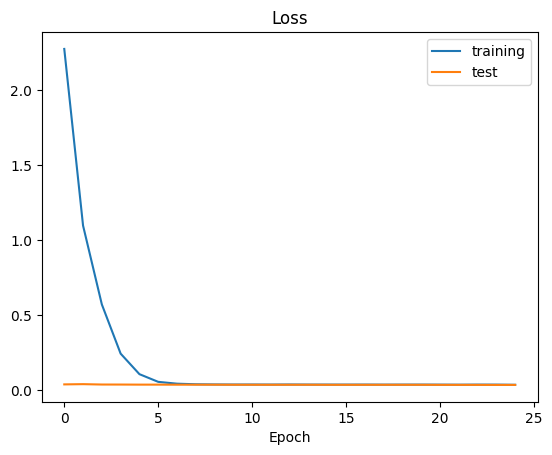

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','test'])
plt.title('Loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

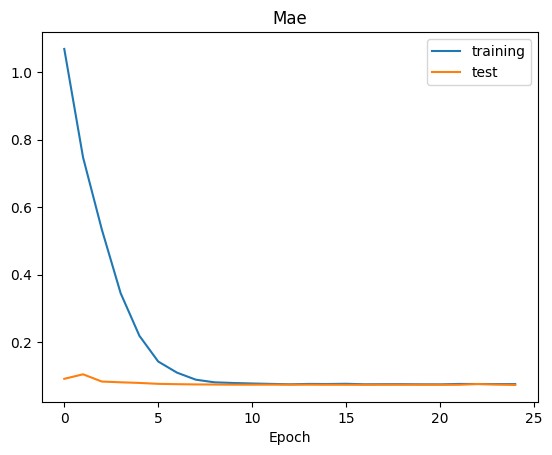

In [60]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['training','test'])
plt.title('Mae')
plt.xlabel('Epoch')

**Saving the Model**

In [61]:
model.save('Saved_Model.h5')